# Brain MRI Tumor Classification 
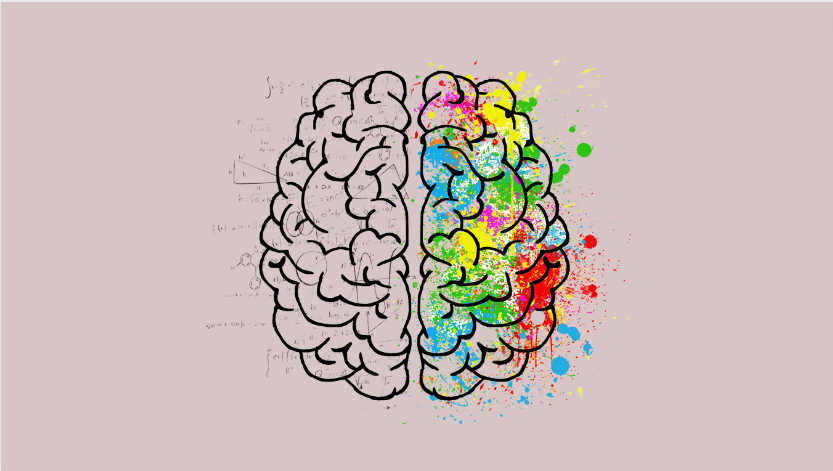


## Introduction
#### In this notebook, I'll build a Convolutional Neural Network (CNN) to perform Image Classification on Brain Tumor MRI images.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from keras import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
from util import plot_acc_loss

In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

## Load and prep data

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    folderPath = os.path.join('../data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 186.39it/s]


In [5]:
df = pd.DataFrame(y_train)

In [6]:
df.value_counts()

meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
dtype: int64

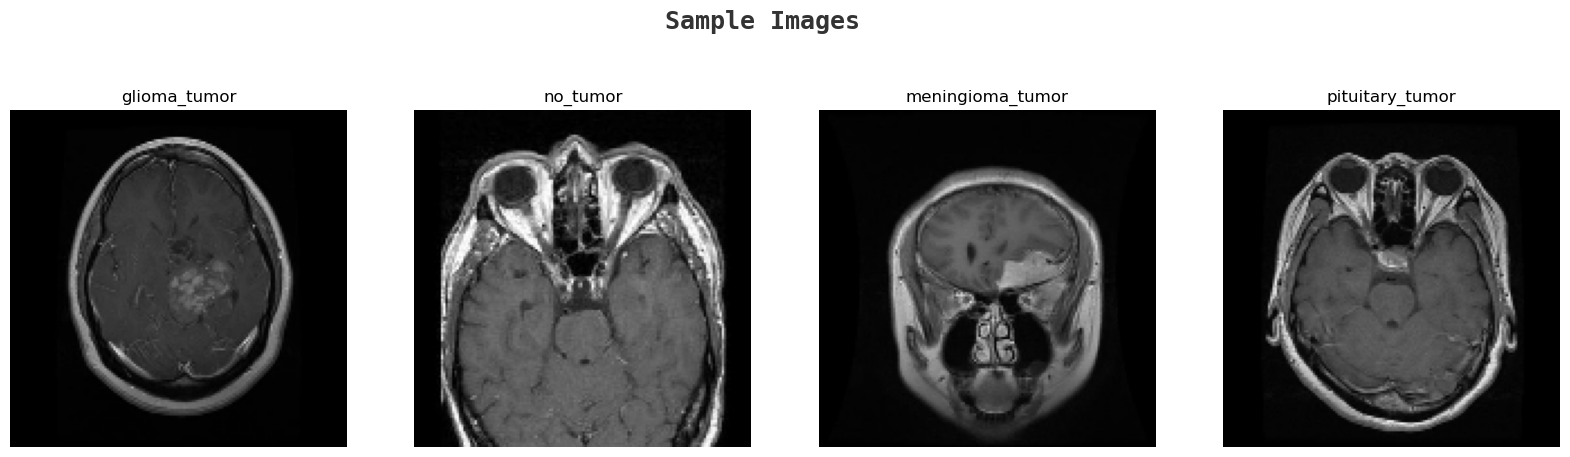

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='       Sample Images',
         size=18,
         fontweight='bold',
         fontname='monospace',
         # color=colors_dark[1],
         y=0.62,
         x=0.4,
         alpha=0.8
        )

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

 Split data for training and testing

In [8]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20)

One hot encode target values

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
X_train.shape

(2611, 150, 150, 3)

Data is now prepped and split for training/testing. Will save here for easy loading during future use.

In [11]:
# # save data to .npy file 
# np.save('../saves/data/x_train.npy', X_train)
# np.save('../saves/data/x_test.npy', X_test)

# np.save('../saves/data/y_train.npy', y_train)
# np.save('../saves/data/y_test.npy', y_test)

---
## Model Building
### Convolutional Neural Networks are great for computer image problems, as they break down and generalize/learn from pixel images

---

Building simple baseline CNN with few layers

In [12]:
cnn = Sequential([
        # ccn network
        Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        # dense network
        Flatten(),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
])

In [13]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
           )

In [14]:
baseline = cnn.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=32)

Epoch 1/12
74/74 [==============================] - 20s 271ms/step - loss: 63.6832 - accuracy: 0.5194 - val_loss: 0.7315 - val_accuracy: 0.7557
Epoch 2/12
74/74 [==============================] - 21s 281ms/step - loss: 0.4647 - accuracy: 0.8365 - val_loss: 0.5283 - val_accuracy: 0.8168
Epoch 3/12
74/74 [==============================] - 22s 293ms/step - loss: 0.1395 - accuracy: 0.9519 - val_loss: 0.5112 - val_accuracy: 0.8321
Epoch 4/12
74/74 [==============================] - 22s 293ms/step - loss: 0.0601 - accuracy: 0.9847 - val_loss: 0.5629 - val_accuracy: 0.8740
Epoch 5/12
74/74 [==============================] - 22s 293ms/step - loss: 0.0312 - accuracy: 0.9894 - val_loss: 0.5314 - val_accuracy: 0.8626
Epoch 6/12
74/74 [==============================] - 22s 293ms/step - loss: 0.0348 - accuracy: 0.9906 - val_loss: 0.5826 - val_accuracy: 0.8779
Epoch 7/12
74/74 [==============================] - 22s 297ms/step - loss: 0.0705 - accuracy: 0.9881 - val_loss: 0.6220 - val_accuracy: 0.855

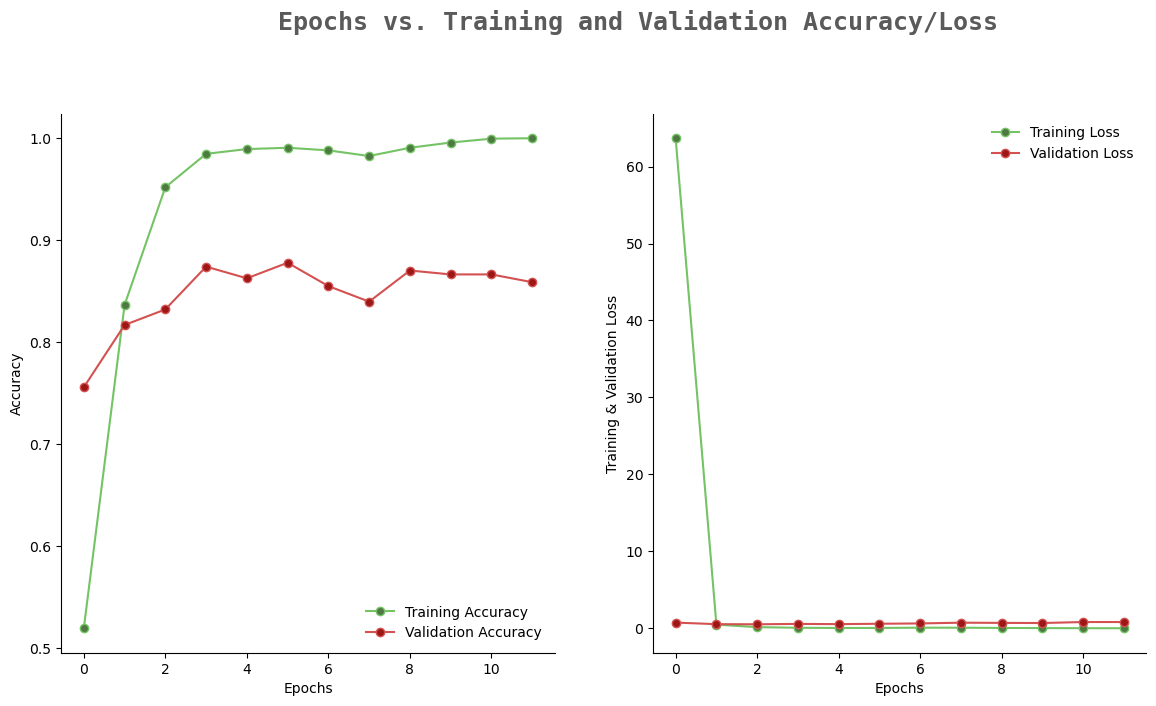

In [16]:
plot_acc_loss(baseline)

---
Save model for re-use

In [17]:
save_path = '../saves/models/base_model.h5'
cnn.save(save_path)

In [33]:
# loaded_model = tf.keras.models.load_model('../saves/models/base_model.h5')

In [51]:
y_pred = cnn.predict(X_test)

21/21 [==============================] - 1s 64ms/step


In [52]:
from sklearn.metrics import confusion_matrix, classification_report

In [53]:
y_pred = np.argmax(y_pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [54]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       190
           1       0.85      0.87      0.86        95
           2       0.82      0.82      0.82       187
           3       0.93      0.97      0.95       181

    accuracy                           0.88       653
   macro avg       0.87      0.88      0.87       653
weighted avg       0.88      0.88      0.88       653



---
Baseline network varying in 80-90% accuracy which is not good enough for our purpose

We will need to use 'transfer learning' and load a state of the art pre-trained model,
to get a more accurate result while saving computational power/time on our local machine.